In [12]:
import torch
import gc
import numpy as np
from torch.utils.data import DataLoader
import time
import sys
sys.path.append("/home/sharfikeg/my_files/retIQA/ret/TReSM")
import torch
from torch import nn
from torch.linalg import vector_norm, lstsq
from torchvision import models
import torchvision.transforms as T
import argparse
from models import Net
import pandas as pd
from PIL import Image
import statistics  
import random
from scipy import stats
from sklearn.model_selection import train_test_split
torch.set_num_threads(24)
import data_loader
import folders
import json
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS
img_num = {
        'csiq':     list(range(0, 30)),
        'kadid10k': list(range(0, 80)),
        'tid2013':  list(range(0, 25)),
        'koniq':    list(range(0, 10073)),
        'spaq':     list(range(0, 11125)),
        'pipal':    list(range(0, 200)),
        'biq':      list(range(0, 11989))
        }

botnet_pretrain="/home/sharfikeg/my_files/VIPNet/pretrained_model/botnet_model_best.pth.tar"
botnet_pretrain_classes=150
my_botnet_pretrain="/home/sharfikeg/my_files/retIQA/dc_ret/my_botnet_pretrain/checkpoint_model_best_heads16.pth"
my_botnet_pretrain_classes=125
logging_path="/home/sharfikeg/my_files/retIQA/dc_ret/DistorsionFeatureExtractor/results.csv"
tres_save_path="/extra_disk_1/sharfikeg/Save_TReS/"

tid2013_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_tid2013_checkpoints/checkpoint_model_best_heads16.pth"
tid2013_data_path="/home/s-kastryulin/data/tid2013/distorted_images/"
tid2013_ref_path="/home/s-kastryulin/data/tid2013/reference_images/"
tid2013_csv_path="/home/sharfikeg/my_files/retIQA/tid2013/tid2013_info.csv"
tid2013_uni_csv_path="/home/sharfikeg/my_files/retIQA/tid2013/tid2013_uni_info.csv"
tid2013_num_classes=120
k_tid=9

kadid10k_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_kadid10k_checkpoints/checkpoint_model_best_heads16.pth"
kadid10k_data_path="/home/sharfikeg/my_files/retIQA/kadid10k/distorted_images/"
kadid10k_ref_path="/home/sharfikeg/my_files/retIQA/kadid10k/reference_images/"
kadid10k_csv_path="/home/sharfikeg/my_files/retIQA/kadid10k/kadid10k_info.csv"
kadid10k_uni_csv_path="/home/sharfikeg/my_files/retIQA/kadid10k/kadid10k_uni_info.csv"
kadid10k_num_classes=125
k_kadid=9

csiq_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_csiq_checkpoints/checkpoint_model_best_heads16.pth"
csiq_data_path="/home/sharfikeg/my_files/retIQA/csiq/distorted_images/"
csiq_ref_path="/home/sharfikeg/my_files/retIQA/csiq/src_imgs/"
csiq_csv_path="/home/sharfikeg/my_files/retIQA/csiq/csiq_info.csv"
csiq_uni_csv_path="/home/sharfikeg/my_files/retIQA/csiq/csiq_uni_info.csv"
csiq_num_classes=30
k_csiq=9

koniq10k_data_path="/home/s-kastryulin/data/koniq10k/512x384/"
koniq10k_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_info.csv"
koniq10k_big_data_path="/home/s-kastryulin/data/koniq10k/1024x768/"
koniq10k_big_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_big_info.csv"
koniq10k_uni_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_uni_info.csv"
k_koniq=30

spaq_data_path="/extra_disk_1/sharfikeg/spaq/TestImage/"
spaq_csv_path="/extra_disk_1/sharfikeg/spaq/spaq_info.csv"
spaq_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/spaq/spaq_uni_info.csv"
k_spaq=50

biq_data_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/Images/"
biq_csv_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/biq_info.csv"
biq_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/biq_uni_info.csv"
k_biq=30

pipal_data_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/Train_Dist/"
pipal_ref_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/Train_Ref/"
pipal_csv_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/pipal_info.csv"
pipal_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/pipal_uni_info.csv"
k_pipal=20

def str_2_float_list(pseudolist):
    intermediate = pseudolist.strip('][').split(', ')
    return list(map(float, intermediate))
def str_2_str_list(pseudolist):
    intermediate = pseudolist.strip('][').split(', ')
    return list(map(str, intermediate))

In [3]:
train, test = train_test_split(img_num['csiq'], test_size=0.2, random_state=3)
csiq = folders.CSIQFolder(
    '/home/sharfikeg/my_files/retIQA/csiq', seed=3, index=test, transform=None, patch_num=1, istrain=False, k=3
)

In [19]:
image[0]

tensor([[[[ 1.7523,  1.7523,  1.7523,  ...,  1.6838,  1.6324,  1.5810],
          [ 1.7523,  1.7523,  1.7523,  ...,  1.6667,  1.6153,  1.5468],
          [ 1.7523,  1.7523,  1.7523,  ...,  1.6667,  1.5810,  1.5125],
          ...,
          [ 0.6906,  0.7077,  0.7419,  ...,  1.1358,  1.1358,  1.1529],
          [ 0.1939,  0.2453,  0.2967,  ...,  1.1529,  1.1700,  1.2043],
          [ 0.5022,  0.5022,  0.4851,  ...,  0.9817,  1.0502,  1.0844]],

         [[ 1.9559,  1.9559,  1.9559,  ...,  1.8508,  1.7983,  1.7458],
          [ 1.9559,  1.9559,  1.9559,  ...,  1.8333,  1.7808,  1.7108],
          [ 1.9559,  1.9559,  1.9559,  ...,  1.8333,  1.7458,  1.6758],
          ...,
          [ 0.6604,  0.6779,  0.7129,  ...,  1.1681,  1.1681,  1.1856],
          [ 0.1702,  0.2227,  0.2752,  ...,  1.2031,  1.2206,  1.2556],
          [ 0.4678,  0.4678,  0.4503,  ...,  1.0280,  1.0980,  1.1331]],

         [[ 2.1171,  2.1171,  2.1171,  ...,  2.0300,  1.9777,  1.9254],
          [ 2.1171,  2.1171,  

In [37]:
targets

tensor([[43.5000, 49.9400, 53.5800, 54.2300, 84.8900, 66.0000, 76.2500, 86.7700,
         57.8300, 80.2000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [80.0000, 79.3300, 72.0000, 57.2000, 75.2000, 36.6000, 75.8300, 83.6700,
         77.0900, 71.1400],
        [48.8000, 35.8000, 57.2000, 46.5700, 29.4000, 33.2900, 36.6000, 19.8000,
         44.0000, 30.5700],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000]])

In [13]:
l1_loss = nn.L1Loss(reduction='none')

In [54]:
labels, preds = torch.rand([5]), torch.rand([5])

In [55]:
labels, preds

(tensor([0.0803, 0.1165, 0.3962, 0.1688, 0.7255]),
 tensor([0.7949, 0.7077, 0.9917, 0.1666, 0.0328]))

In [59]:
targets

tensor([[43.5000, 49.9400, 53.5800, 54.2300, 84.8900, 66.0000, 76.2500, 86.7700,
         57.8300, 80.2000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [80.0000, 79.3300, 72.0000, 57.2000, 75.2000, 36.6000, 75.8300, 83.6700,
         77.0900, 71.1400],
        [48.8000, 35.8000, 57.2000, 46.5700, 29.4000, 33.2900, 36.6000, 19.8000,
         44.0000, 30.5700],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000]])

In [58]:
# mine
indexlabel = torch.argsort(targets, dim=0) # small--> large
anchor1 = torch.unsqueeze(targets[indexlabel[0],...].contiguous(),dim=0) # d_min
positive1 = torch.unsqueeze(targets[indexlabel[1],...].contiguous(),dim=0) # d'_min+
negative1_1 = torch.unsqueeze(targets[indexlabel[-1],...].contiguous(),dim=0) # d_max+

In [61]:
targets[indexlabel[0],...]

tensor([[20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000],
        [20.3000, 19.5700, 24.1400, 33.7500, 19.7500, 29.4000, 24.0000, 30.0000,
         23.5000, 32.6000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [22.3100, 36.9100, 18.9100, 32.2500, 48.6000, 36.0900, 26.1100,  7.0900,
         22.1100,  8.0000],
        [22.3100, 3

In [56]:
# their
indexlabel = torch.argsort(labels) # small--> large
anchor1 = torch.unsqueeze(preds[indexlabel[0],...].contiguous(),dim=0) # d_min
positive1 = torch.unsqueeze(preds[indexlabel[1],...].contiguous(),dim=0) # d'_min+
negative1_1 = torch.unsqueeze(preds[indexlabel[-1],...].contiguous(),dim=0) # d_max+

In [57]:
preds[indexlabel[0]], anchor1

(tensor(0.7949), tensor([0.7949]))

In [38]:
torch.argsort(targets, dim=0)

tensor([[4, 4, 1, 1, 4, 4, 4, 1, 1, 1],
        [1, 3, 4, 4, 3, 3, 1, 3, 4, 3],
        [0, 1, 0, 3, 1, 1, 3, 4, 3, 4],
        [3, 0, 3, 0, 2, 2, 2, 2, 0, 2],
        [2, 2, 2, 2, 0, 0, 0, 0, 2, 0]])

In [62]:
resnet = models.resnet50(weights="DEFAULT")

In [21]:
backbone_config = argparse.Namespace()
backbone_config.network = 'resnet50'
backbone_config.nheadt = 16
backbone_config.num_encoder_layerst = 2
backbone_config.dim_feedforwardt = 64
backbone_config.device = "cpu"
backbone_config.k = 3
backbone_config.multi_return = 1
m = Net(backbone_config, "cpu")


In [31]:
for parameter in m.parameters():
    parameter.requires_grad = False
for parameter in m.fc.parameters():
    parameter.requires_grad = True
sum(p.numel() for p in m.parameters() if p.requires_grad)

16388

In [57]:
seed = 1
path = f"/extra_disk_1/sharfikeg/Save_TReSS/csiq_1_{seed}/k_3/lr_0.0002_lrratio1/no_finetune/single_return/PLCC_SRCC_1_{seed}.json"
f = open(path, "r")
scores = json.loads(f.read())

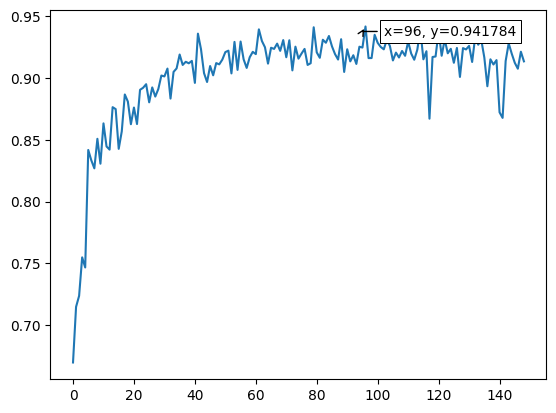

In [58]:
x,y= zip(*scores.items()) 

x = np.array(list(map(int, x)))
y = np.array(y)[:,0]

fig,ax = plt.subplots()
ax.plot(x , y)

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={}, y={:.6f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)
plt.show()

In [59]:
y.argsort()

array([  0,   1,   2,   4,   3,   7,   9,   6,   5,  12,  15,  11,   8,
        16,  19,  21,  10, 117, 141, 140,  14,  20,  13,  25,  18,  32,
        27,  17,  22,  28,  23,  26, 136,  24,  40,  44, 127,  30,  29,
        46,  52,  43,  89,  33,  72,  54, 146,  31,  34,  57,  45,  36,
        77, 138,  48,  93,  64,  38,  78,  47, 125, 145, 131,  37,  91,
       148, 142,  39, 105, 139, 112,  49,  87,  56, 115, 137,  74,  97,
        98,  81, 107, 135,  70,  58, 118, 119, 109, 121,  92,  35,  60,
        86, 144,  75, 111, 123, 106,  80,  50,  59, 147, 116, 108,  68,
        51, 113, 129, 102,  90,  42,  66,  76, 124, 128, 126,  65,  95,
        63, 101,  94,  73,  85, 104, 130, 133,  67, 143, 100,  83,  53,
       110,  55,  62,  71,  69, 134, 103,  82, 122,  88, 132,  84,  99,
        41, 120, 114,  61,  79,  96])